# Introduksjon til Dijkstra's algoritme for å finne korteste vei i rettet graf

Nyttige ressurser:
- YouTube-video med god gjennomgang (se spesielt "Eager Dijkstra's"): https://www.youtube.com/watch?v=pSqmAO-m7Lk&t=605s
- Eksempel på bruk av Dijkstra's på "spillbrett": https://www.redblobgames.com/pathfinding/a-star/introduction.html#dijkstra
- Wikipedia: https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm

## Dataformat
Vi antar at vi kjenner alle noder og alle vekter mellom noder. Denne informasjonen kan lagres i f.eks. en "adjacency matrix" eller en "adjacency list". Vi tar utgangspunkt i en adjacency list som er implementert som en "2-lags dictionary". Keys i "ytterste lag" tilsvarer navnet på hver node. Value i "ytterste lag" tilsvarer en dict med navn på nabonodene, og vektene på kantene som leder dit.

In [1]:
adj_list = {'A':{'B':4, 'C':2},
            'B':{'C':5, 'D':10},
            'C':{'A':9, 'D':2},
            'D':{'B':12}}

In [2]:
from graphviz import Digraph, Graph

def dict_to_dot(adj_dict, weighted=False, directed=False):
    """ Create graphviz graph based on adjancency list (dictionary) 
    
    # Input parameters:
    adj_dict     - Adjacency list as dictionary
                   key = node name
                   if weighted: adj_dict values are dicts with keys = neighbor node names,
                       values = neighbor node edge weights
                   if not weighted: value = iterable with neighbor node names
    weighted     - Boolean, True if adj_dict describes a weighted graph
    directed     - Boolean, True for directed graph, False for undirected.
    
    # Returns:
    graph_dot    - Graphviz graph object (Graph or Digraph)
    
    """ 
    
    if directed:
        graph_dot = Digraph(strict=True)
    else:
        graph_dot = Graph(strict=True)
    
    for from_vertex in adj_dict.keys():
        if weighted:
            for to_vertex in adj_dict[from_vertex].keys():    # Assume dict of dicts
                graph_dot.edge(tail_name = from_vertex,
                           head_name = to_vertex,
                           label = str(adj_dict[from_vertex][to_vertex]))
        else:
            for to_vertex in adj_dict[from_vertex]:           # Assume dict of iterables
                graph_dot.edge(tail_name = from_vertex,
                           head_name = to_vertex)
    
    return graph_dot

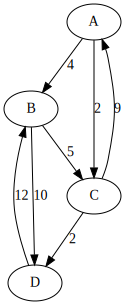

In [3]:
graph = dict_to_dot(adj_list,weighted=True,directed=True)
graph

## Pseudokode
Hensikten med Dijkstra's algoritme er å finne korteste distanse (dvs. sum av vekter på kantene man må gå langs) for å komme fra en node til en annen. Vi kan dele dette opp i to tilfeller:
1) Finne korteste distanse fra startnode til _alle_ noder. La oss kalle  dette "dijkstra_graph_traversal"
2) Finne korteste distanse fra startnode til _en enkelt_ node. Vi kaller dette "dijktra_single_endnode"

I tilfelle 1 kan vi tenke oss at vi må traversere hele grafen (besøke alle nodene) med utgangspunkt i startnoden. I tilfelle 2 kan vi "stoppe tidlig" så snart vi finner sluttnoden (vi kommer tilbake til hvorfor dette er mulig). Tilfelle 2 vil ta kortere tid enn tilfelle 1. 

### Pseudokode, initialbetingelser for algoritmen
- Lag datastruktur "distanse"': Korteste distansen til hver node. Default: "uendelig"
- Lag datastruktur "besøkt": Hvilke noder har vært besøkt. Default: False
- Lag datastruktur "kom fra": Hva var forrige node (langs korteste vei) til denne noden.
- Lag prioritetskø: Inneholder "oppdagede" noder som ikke har vært besøkt. Node med korteste distanse ligger først.
- "Oppdag" startnoden: Sett distanse til null, og legg startnoden i prioritetskøen. 

### Pseudokode, dijkstra_graph_traversal (besøk alle noder)
- Mens det fortsatt finnes noder i prioritetskøen:
    - Hent ut noden med kortest distanse, og marker denne som besøkt
    - For alle naboer:
        - Hvis naboen ikke har blitt besøkt: 
            - Hvis naboen ikke ligger i prioritetskøen:
                - Legg naboen i prioritetskøen
            - Hvis distansen til noden + vekten på kanten til naboen < minste distanse til naboen funnet så langt:
                - Oppdater distansen til naboen
                - Oppdater "kom fra" for naboen: Settes lik noden man står i 
            
### Pseudokode, dijkstra_single_endnode (korteste vei til en enkelt node, "early stopping")
- Mens det fortsatt finnes noder i prioritetskøen:
    - Hent ut noden med kortest distanse, og marker denne som besøkt
    - *Hvis noden er endenoden: Stopp iterasjonen (korteste distanse funnet)*. 
    - For alle naboer:
        - Hvis naboen ikke har blitt besøkt: 
            - Hvis naboen ikke ligger i prioritetskøen:
                - Legg naboen i prioritetskøen
            - Hvis distansen til noden + vekten på kanten til naboen < minste distanse til naboen funnet så langt:
                - Oppdater distansen til naboen
                - Oppdater "kom fra" for naboen: Settes lik noden man står i 
            
### Pseudokode: Finne nodene som utgjør korteste distanse
- Start i endenoden
- Inntil vi kommer tilbake til startnoden:
    - Legg noden i liste over noder langs korteste vei
    - Hopp til nodens "forrige". 

*Kommentar: I noen grafer finnes det mer enn en korteste vei: Det kan finnes flere "stier" gjennom grafen som gir samme (korteste) distanse, og algoritmen over gir bare en av disse. Dersom man er interessert i å finne alle, må man tillate at "forrige node" ikke bare er en enkelt node, men potensielt flere noder, som alle gir samme (minste) distanse fram til noden man står i.* 

# Verktøy og datastrukturer
Det er mulig å bruke dictionaries / arrays for å logge distansen fram til hver node, og hva som var forrige node. Men det enkleste er kanskje å betrakte hver node som et objekt som holder på denne informasjonen: 

In [4]:
class VertexTemplate:
    def __init__(self,name, dist=float('inf'), prev=None):
        self.name = name       # Must be unique
        self.dist = dist       # Current distance from start node
        self.prev = prev       # Pointer to previous node (along shortest path from start)

Det er vanlig å bruke en "min-heap" for å implementere en prioritetskø. Vi kan bruke pythons ["heapq"](https://docs.python.org/3/library/heapq.html) :

In [5]:
import heapq
import random

"heapq"-modulen har ikke en egen klasse for prioritetskø, men tar utgangspunkt i vanlige lister, og definerer heap-relaterte funksjoner for å manipulere listene.

In [6]:
# Create a list of random numbers
q = [random.randint(0,100) for _ in range(10)]
print(q)

[14, 1, 34, 15, 15, 26, 16, 17, 17, 64]


In [7]:
# Heapify the list
heapq.heapify(q)
print(q)

[1, 14, 16, 15, 15, 26, 34, 17, 17, 64]


In [8]:
# Pop element from list
smallest = heapq.heappop(q)
print(smallest)
print(q)

1
[14, 15, 16, 15, 64, 26, 34, 17, 17]


Vi prøver å bruke heapq for å sortere våre node-objekter:

In [9]:
v1 = VertexTemplate('A',dist=10)
v2 = VertexTemplate('B',dist=3)
v3 = VertexTemplate('C',dist=10)
v4 = VertexTemplate('D',dist=6)
vq1 = [v1, v2, v3, v4]

In [10]:
heapq.heapify(vq1)

TypeError: '<' not supported between instances of 'VertexTemplate' and 'VertexTemplate'

Vi ser at heapq trenger å kunne sammenligne nodene ("less than") for å kunne sortere dem riktig. Vi gjør dette ved å implementere dunder-metoden \__lt\__ . I samme omgang implementerer vi en metode for å representere noden som en tekststreng, med navn og vekt på noden.

In [11]:
class Vertex(VertexTemplate):
    def __lt__(self,other):
        return self.dist < other.dist
    
    def __str__(self):
        return('(' + self.name + ', ' + str(self.dist) + ')' ) 
    

In [12]:
v1 = Vertex('A',dist=10)
v2 = Vertex('B',dist=3)
v3 = Vertex('C',dist=10)
v4 = Vertex('D',dist=6)
vq2 = [v1, v2, v3, v4]

In [13]:
heapq.heapify(vq2)
for node in vq2:
    print(node)

(B, 3)
(D, 6)
(C, 10)
(A, 10)


Vi ser at noden med minst distanse ligger øverst, som er det vi ønsker i en prioritetskø. Vær obs på at dersom vi endrer distansen (dvs. prioriteten) til en av nodene, vil ikke heap'en oppdateres automatisk.

In [14]:
# Change priority and print current heap
v3.dist = 2
for node in vq2:
    print(node)

(B, 3)
(D, 6)
(C, 2)
(A, 10)


In [15]:
# Heap must be "re-heapified" manually
heapq.heapify(vq2)
for node in vq2:
    print(node)

(C, 2)
(D, 6)
(B, 3)
(A, 10)


Et alternativ til heapq er f.eks. denne implementasjonen av heap som en dict: https://github.com/DanielStutzbach/heapdict
Denne har metoden \_decrease_key() som kan brukes for å oppdatere prioriteten til en node (har ikke testet denne). 